# 개요

* 아래의 목적/이유로 참가한 스터디에 대한 기록
  * SQLD취득 후 장기 미사용 & GPT를 통한 SQL사용 등으로 많이 잊은 SQL을 복기
  * 기존에 사용해 본 Optuna가 아닌 Autogluon이 커리큘럼에 있어 익혀보고자 함
  * 기존에 관심있던 XAI(설명가능한 AI)를 익히고자 함

* 3주차 과제 진행
  * 지정과제에 대한 EDA, 전처리, 데이터마트(CSV파일)만들기
    * 데이터마트는 sqlite3으로 DB형태로 만듦 
  * 변수에 대한 설명 확인
  * 수치/명목형 변수로 나누어 EDA 및 전처리 진행
  * 향후 Test데이터 등에도 사용하기 위해 전처리 함수로 정리

# 3주차 과제 

## 과제 설명

* 과제 : 월간 데이콘 신용카드 사용자 연체 예측 AI 경진대회
  * https://dacon.io/competitions/official/235713/overview/description
* EDA, 전처리, 데이터마트(CSV파일 등)만들고, 그 과정이 담긴 ipynb제출

## 변수 설명 확인하기

* [원본링크](https://www.dacon.io/competitions/official/235713/talkboard/402821/?_gl=1%2a1qi5pgu%2a_gcl_au%2aMTY1MzAzMjUwMi4xNzMyNDU0MDQ2%2a_ga%2aNTU2Mjg0MDUwLjE3MjQxMzkwODk.%2a_ga_35PZM515YN%2aMTczNjI1MzI0NS4xOC4xLjE3MzYyNTMyNjQuNDEuMC4w)
* 변수별 설명
  * gender: 성별
  * car: 차량 소유 여부
  * reality: 부동산 소유 여부
  * child_num: 자녀 수
  * income_total: 연간 소득
  * income_type: 소득 분류
    * ['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']
  * edu_type: 교육 수준
    * ['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']
  * family_type: 결혼 여부
    * ['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']
  * house_type: 생활 방식
    * ['Municipal apartment', 'House / apartment', 'With parents', 'Co-op apartment', 'Rented apartment', 'Office apartment']
  * DAYS_BIRTH: 출생일
    * 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미
  * DAYS_EMPLOYED: 업무 시작일
    * 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미
    * 양수 값은 고용되지 않은 상태를 의미함
  * FLAG_MOBIL: 핸드폰 소유 여부
  * work_phone: 업무용 전화 소유 여부
  * phone: 전화 소유 여부
  * email: 이메일 소유 여부
  * occyp_type: 직업 유형													
  * family_size: 가족 규모
  * begin_month: 신용카드 발급 월
    * 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미
  * **credit**: 사용자의 신용카드 대금 연체를 기준으로 한 신용도
    * 낮을 수록 높은 신용의 신용카드 사용자를 의미함

## 데이터 읽고 기초적인 정보 확인하기

* 데이터 로딩하기

In [ ]:
from pkb_sqlite3 import DB_sqlite3

db_controller = DB_sqlite3('Dacon_creditcard_overdue.db')
df_train = db_controller.search_db_show_df('SELECT * FROM train')
df_test = db_controller.search_db_show_df('SELECT * FROM test')
df_sample_submission = db_controller.search_db_show_df('SELECT * FROM sample_submission')

In [ ]:
# 데이터 형태(잘 로딩되었는지 확인)

print(f"""{df_train.shape}
{df_test.shape}""")

(26457, 20)
(10000, 19)


* describe()를 활용해 정보 확인하기
  * count값을 보면, occyp_type에만 Null(결측치)값이 있음
    * occyp_type : 결측치가 8천여개로 Drop이 아닌 대체 필요
  * Unique값이 있는 컬럼들은 범주형 변수로 추측
  * count/unique/freq값을 보면, 데이터가 편향된 컬럼 있음
    * 예를 들어, gender는 26,457 중 17,697로 약 65%로 F값이 많음(top)
  * DAYS_BIRTH나 begin_month는 음수 변수로 로그변환 제외

In [ ]:
df_train.describe(include='all').transpose().reset_index()

,index,count,unique,top,freq,mean,std,min,25%,50%,75%,max
0,index,26457.0,NaN,NaN,NaN,13228.0,7637.622372,0.0,6614.0,13228.0,19842.0,26456.0
1,gender,26457,2,F,17697,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,car,26457,2,N,16410,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,reality,26457,2,Y,17830,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,child_num,26457.0,NaN,NaN,NaN,0.428658,0.747326,0.0,0.0,0.0,1.0,19.0
5,income_total,26457.0,NaN,NaN,NaN,187306.524493,101878.367995,27000.0,121500.0,157500.0,225000.0,1575000.0
6,income_type,26457,5,Working,13645,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,edu_type,26457,5,Secondary / secondary special,17995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,family_type,26457,5,Married,18196,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,house_type,26457,6,House / apartment,23653,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 데이터 나누기
y_train = df_train['credit'].copy()
x_train = df_train.drop('credit',axis=1).copy()

print(f"""{x_train.shape}
{y_train.shape}""")

(26457, 19)
(26457,)


## [EDA] 수치형 변수 : 기초 통계량 확인

### 왜도

* 왜도를 구해 표로 정리했으며, 시각화를 통해 추가 확인하기로 함

In [ ]:
x_numerical = x_train.select_dtypes(include=['float64', 'int64'])
numeric_skew = x_numerical.skew().reset_index() # skew() 함수로 왜도 구하기
numeric_skew

,index,0
0,index,0.000000
1,child_num,2.852376
2,income_total,2.659271
3,DAYS_BIRTH,-0.185986
4,DAYS_EMPLOYED,1.777596
5,FLAG_MOBIL,0.000000
6,work_phone,1.318953
7,phone,0.903042
8,email,2.838422
9,family_size,1.431759


### 첨도

* 첨도를 구해 표로 정리했으며, 시각화를 통해 추가 확인하기로 함

In [ ]:
numeric_kurt = x_numerical.kurtosis().reset_index()
numeric_kurt

,index,0
0,index,-1.200000
1,child_num,29.172394
2,income_total,16.359621
3,DAYS_BIRTH,-1.046188
4,DAYS_EMPLOYED,1.161734
5,FLAG_MOBIL,0.000000
6,work_phone,-0.260383
7,phone,-1.184604
8,email,6.057100
9,family_size,10.578051


### 히스토그램 시각화

* 히스토그램으로 시각화했고, 일부 분포의 판단이 힘든 값에 대해서는 재조정하여 시각화
* 아래 변수들은 유무를 0,1로만 표현한 변수로, 추가적인 시각화에서 제외함
  * work_phone, phone, email

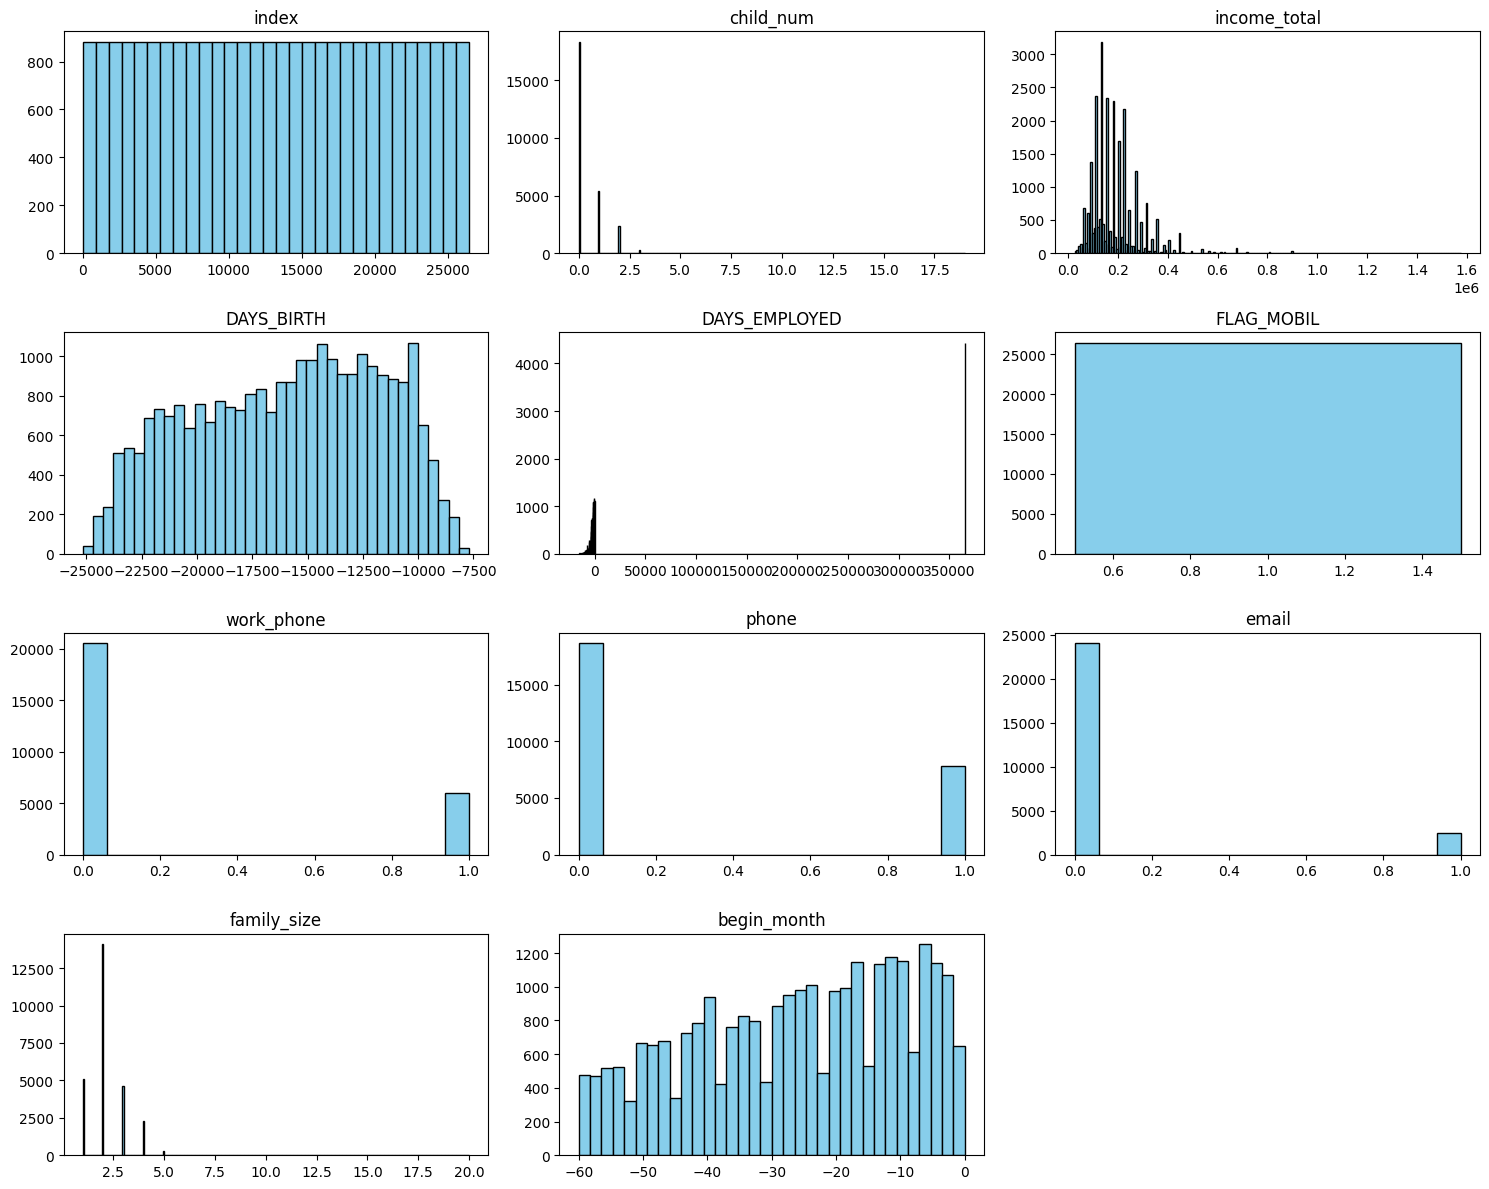

In [ ]:
import matplotlib.pyplot as plt
import math

# 설정: 가로 그래프 개수
cols = 3
num_vars = len(x_numerical.columns)
rows = math.ceil(num_vars / cols)  # 필요한 행(row) 수 계산

# 서브플롯 생성
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))  # 전체 figure 크기 조정
axes = axes.flatten()  # 2D 배열을 1D로 변환하여 인덱싱 편리하게

# 그래프 그리기
for var_idx, var_nm in enumerate(x_numerical.columns):
    ax = axes[var_idx]
    ax.hist(x_numerical.iloc[:, var_idx], bins='auto', color='skyblue', edgecolor='black')
    ax.set_title(f'{var_nm}')

# 빈 서브플롯 숨기기
for i in range(num_vars, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

* 재조정하여 시각화한 내용을 기반으로, 아래와 같이 결정함
  * 뚜렷하게 쏠림(높은 왜도)을 보이는 'DAYS_EMPLOYED'에 대해 로그변환 진행
  * 첨도가 3보다 낮은, 'DAYS_BIRTH'와 'begin_month에 대해 표준화 진행

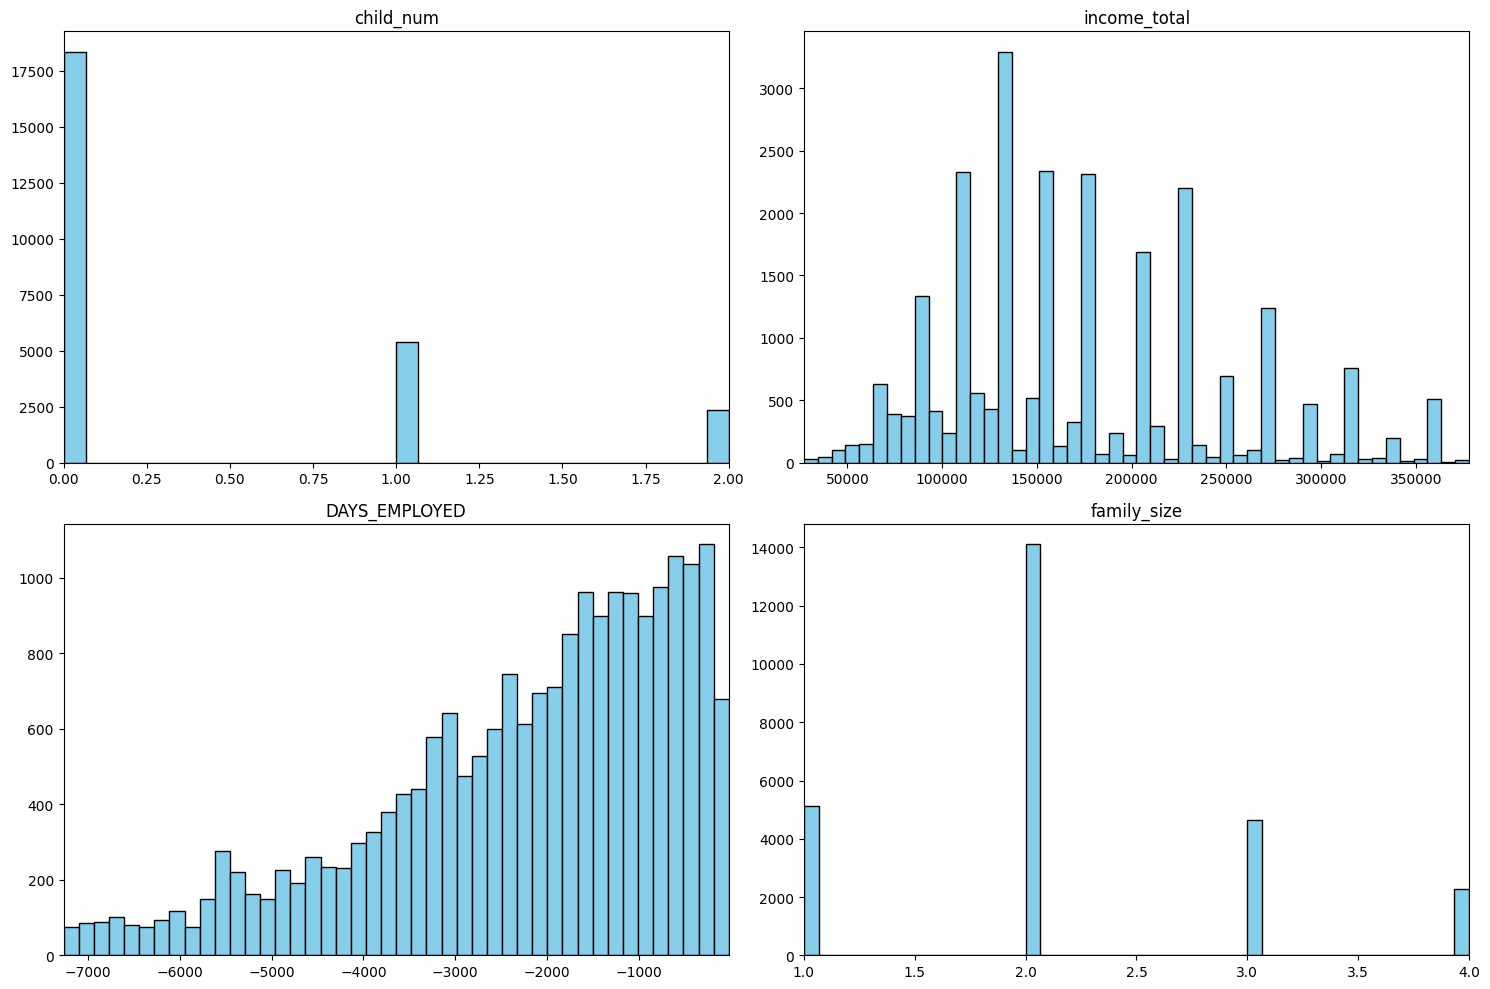

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 설정: 가로 그래프 개수와 세로 그래프 개수
rows = 2
cols = 2

# 서브플롯 생성
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))  # 전체 figure 크기 조정
axes = axes.flatten()  # 2D 배열을 1D로 변환하여 인덱싱 편리하게

# 그래프 그리기
plot_count = 0
for var_idx, var_nm in enumerate(x_numerical.columns):
    if var_nm in ['child_num', 'income_total', 'DAYS_EMPLOYED', 'family_size']:
        ax = axes[plot_count]
        data = x_numerical.iloc[:, var_idx]

        # 이상치 제외를 위한 사분위수 계산
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # 이상치를 제외한 데이터
        filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]

        ax.hist(filtered_data, bins='auto', color='skyblue', edgecolor='black')
        ax.set_title(f'{var_nm}')
        ax.set_xlim(filtered_data.min(), filtered_data.max())  # x축의 최소값과 최대값 설정
        plot_count += 1

# 빈 서브플롯 숨기기
for i in range(plot_count, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


### 이상치

* 전체 26,457 row중, 일부 이상치가 많아보이는 컬럼 있음
  * 대상 : child_num, income_total, DAYS_EMPLOYED, work_phone, email, family_size
* 변수 설명 내용 중 '소유 여부'인 변수(work_phone, email)를 확인 결과, 0 & 1만 있어 제외
  * 남은 대상 : child_num, income_total, DAYS_EMPLOYED, family_size
* Box plot을 그려보았으나, 시각화만으로는 판단이 어려워 추가적으로 확인하기로 함

In [ ]:
# 수업시간에 사용한 IQR기준 이상치함수 활용

def detect_outliers_fast(df):
    # Calculate IQR without NaN values
    Q1 = df.quantile(0.25, interpolation='midpoint')
    Q3 = df.quantile(0.75, interpolation='midpoint')
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Vectorized outlier detection with NaN handling
    outlier_flags = df.apply(
        lambda col: ~col.between(lower_bound[col.name], upper_bound[col.name]) & col.notna()
    )
    return outlier_flags


# 구한 이상치가 0인 경우를 제외하고 표기
x_outliers = detect_outliers_fast(x_numerical)
outliers_to_see = x_outliers.sum()[x_outliers.sum()>0]
outliers_to_see

child_num         369
income_total     1129
DAYS_EMPLOYED    5726
work_phone       5946
email            2415
family_size       350
dtype: int64

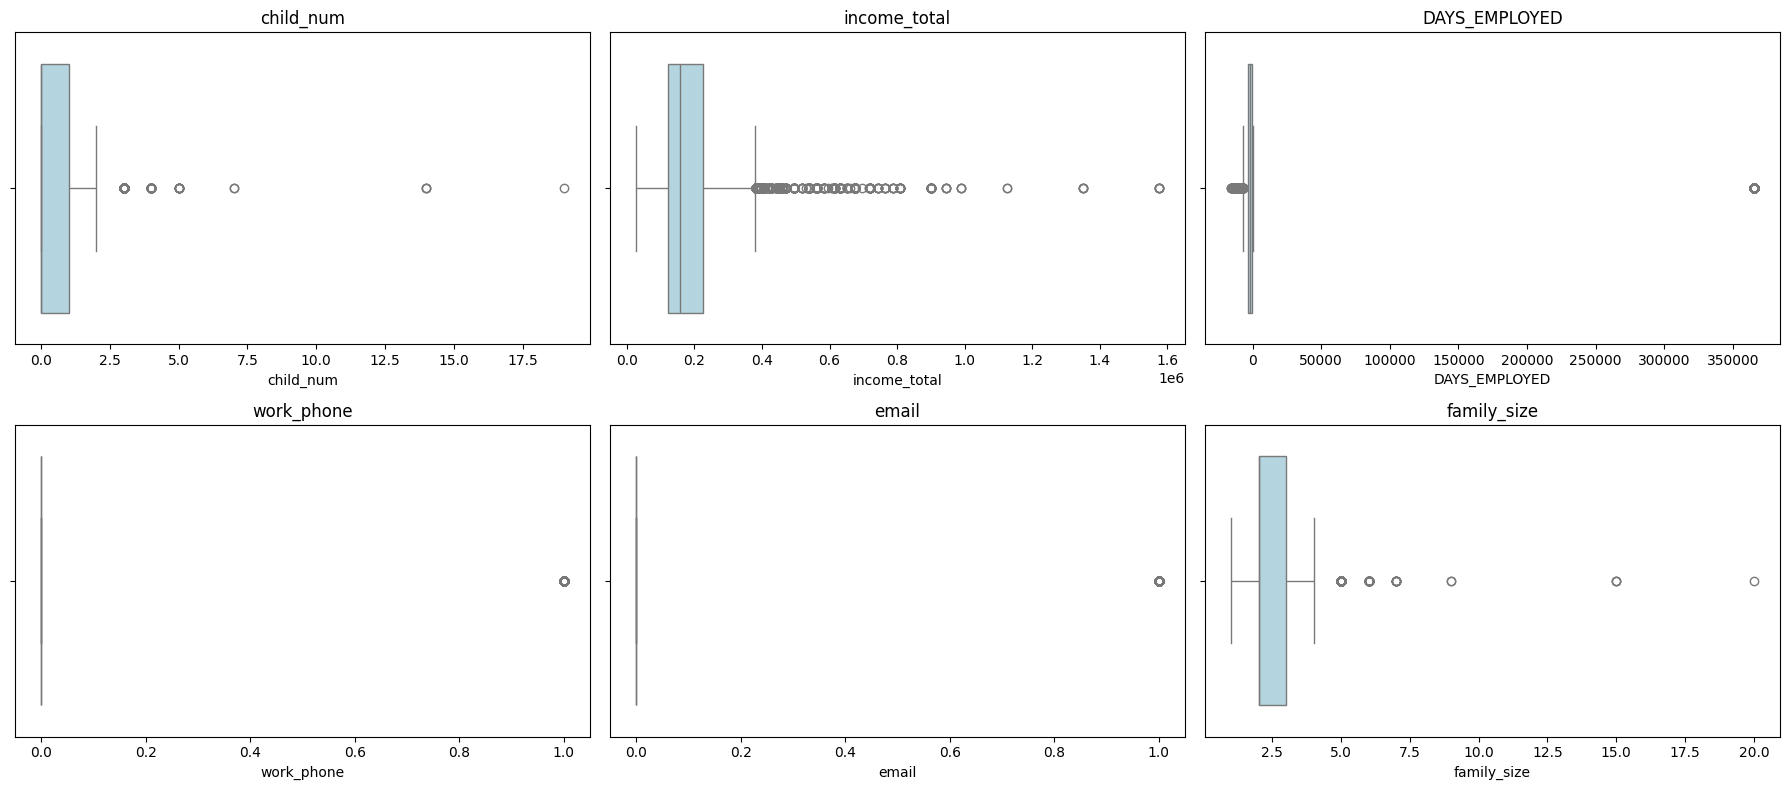

In [ ]:
import matplotlib.pyplot as plt
import math
import seaborn as sns


# 설정: 가로 그래프 개수
cols = 3
num_vars = len(outliers_to_see.index)
rows = math.ceil(num_vars / cols)  # 필요한 행(row) 수 계산

# 서브플롯 생성
fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4))  # 전체 figure 크기 조정
axes = axes.flatten()  # 2D 배열을 1D로 변환하여 인덱싱 편리하게

# 그래프 그리기
for var_idx, var_nm in enumerate(outliers_to_see.index):
    ax = axes[var_idx]
    sns.boxplot(x=x_numerical[var_nm], ax=ax, color='lightblue')
    ax.set_title(f'{var_nm}')
    ax.set_xlabel(var_nm)

# 빈 서브플롯 숨기기
for i in range(num_vars, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

* 각 변수에 대해 확인한 결과 아래와 같으며, 제외할지 등에 대한 판단이 어려움
  * child_num : 자녀가 19명인 경우는 확실히 이상치라는 느낌이지만, 3명의 경우는 이상치로 보기 어려워 보임
  * family_size : 가족구성원이 5명인 경우도 이상치라고 해야할지 모호함
  * DAYS_EMPLOYED는 추가로 확인해보니 미취업여부를 나타내기 위한 양수인 365243 다음으로 큰 수가 -17.
    * 불필요하게 큰 숫자로, 1로 대체
* 각 변수의 이상치에 대해, 값 Drop이 아닌 변환 진행

In [ ]:
def summarize_unique_outliers(x_numerical, x_outliers):
    # 각 컬럼별로 이상치의 고유값을 추출하여 딕셔너리로 저장
    unique_outliers = x_numerical[x_outliers].apply(lambda col: col.unique().tolist())

    # 딕셔너리 형태로 반환
    unique_outliers_dict = unique_outliers.to_dict()

    return unique_outliers_dict


unique_outliers = summarize_unique_outliers(x_numerical, x_outliers)

print(f"""* 이상치로 판명된 Unique값 현황
child_num : {unique_outliers['child_num']}
income_total : {unique_outliers['income_total']}
DAYS_EMPLOYED : {unique_outliers['DAYS_EMPLOYED']}
family_size : {unique_outliers['family_size']}""")

* 이상치로 판명된 Unique값 현황
child_num : [nan, 3.0, 4.0, 5.0, 14.0, 19.0, 7.0]
income_total : [nan, 450000.0, 405000.0, 585000.0, 495000.0, 382500.0, 387000.0, 540000.0, 459000.0, 720000.0, 427500.0, 562500.0, 630000.0, 463500.0, 432000.0, 787500.0, 900000.0, 391500.0, 716323.5, 675000.0, 990000.0, 612000.0, 1575000.0, 652500.0, 945000.0, 418500.0, 634500.0, 423000.0, 742500.0, 517500.0, 560250.0, 810000.0, 445500.0, 616500.0, 765000.0, 396000.0, 472500.0, 594000.0, 468000.0, 661500.0, 441000.0, 494100.0, 531000.0, 607500.0, 414000.0, 697500.0, 1125000.0, 1350000.0]
DAYS_EMPLOYED : [nan, 365243.0, -9391.0, -9404.0, -12332.0, -8491.0, -9988.0, -11940.0, -7400.0, -10993.0, -9870.0, -8091.0, -9957.0, -7310.0, -11062.0, -7679.0, -7514.0, -8671.0, -10773.0, -8284.0, -10121.0, -7369.0, -12278.0, -7415.0, -7401.0, -10050.0, -8553.0, -7593.0, -11494.0, -9052.0, -9269.0, -7835.0, -9683.0, -9858.0, -7346.0, -10490.0, -9925.0, -9029.0, -7838.0, -7553.0, -7379.0, -8171.0, -8375.0, -7536.0, -10600.0, -785

##  [EDA] 범주형 변수 : 시각화 확인

* edu_type(교육 수준)은 순서가 중요한 변수이므로 Label Encoder로 우선순위를 지정하는 것을 고려
* 이외 변수는 모델의 혼동(상위관계 여부)을 방지하고자 One-hot인코딩 고려
  * 대다수의 변수가 2~6개의 unique값을 가져 크게 어려움은 없을 것으로 보임
  * 그러나 occyp_type(직업유형)의 경우는 값이 많은 관계로 좀 더 고민이 필요할 것으로 보임
* 구간화는 도메인지식이 많지 않으므로 진행하지 않음

In [ ]:
# 범주형 변수 추리기
x_categorical = x_train.select_dtypes(include=['object'])
x_categorical.head(5)

,gender,car,reality,income_type,edu_type,family_type,house_type,occyp_type
0,F,N,N,Commercial associate,Higher education,Married,Municipal apartment,None
1,F,N,Y,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,Laborers
2,M,Y,Y,Working,Higher education,Married,House / apartment,Managers
3,F,N,Y,Commercial associate,Secondary / secondary special,Married,House / apartment,Sales staff
4,F,Y,Y,State servant,Higher education,Married,House / apartment,Managers


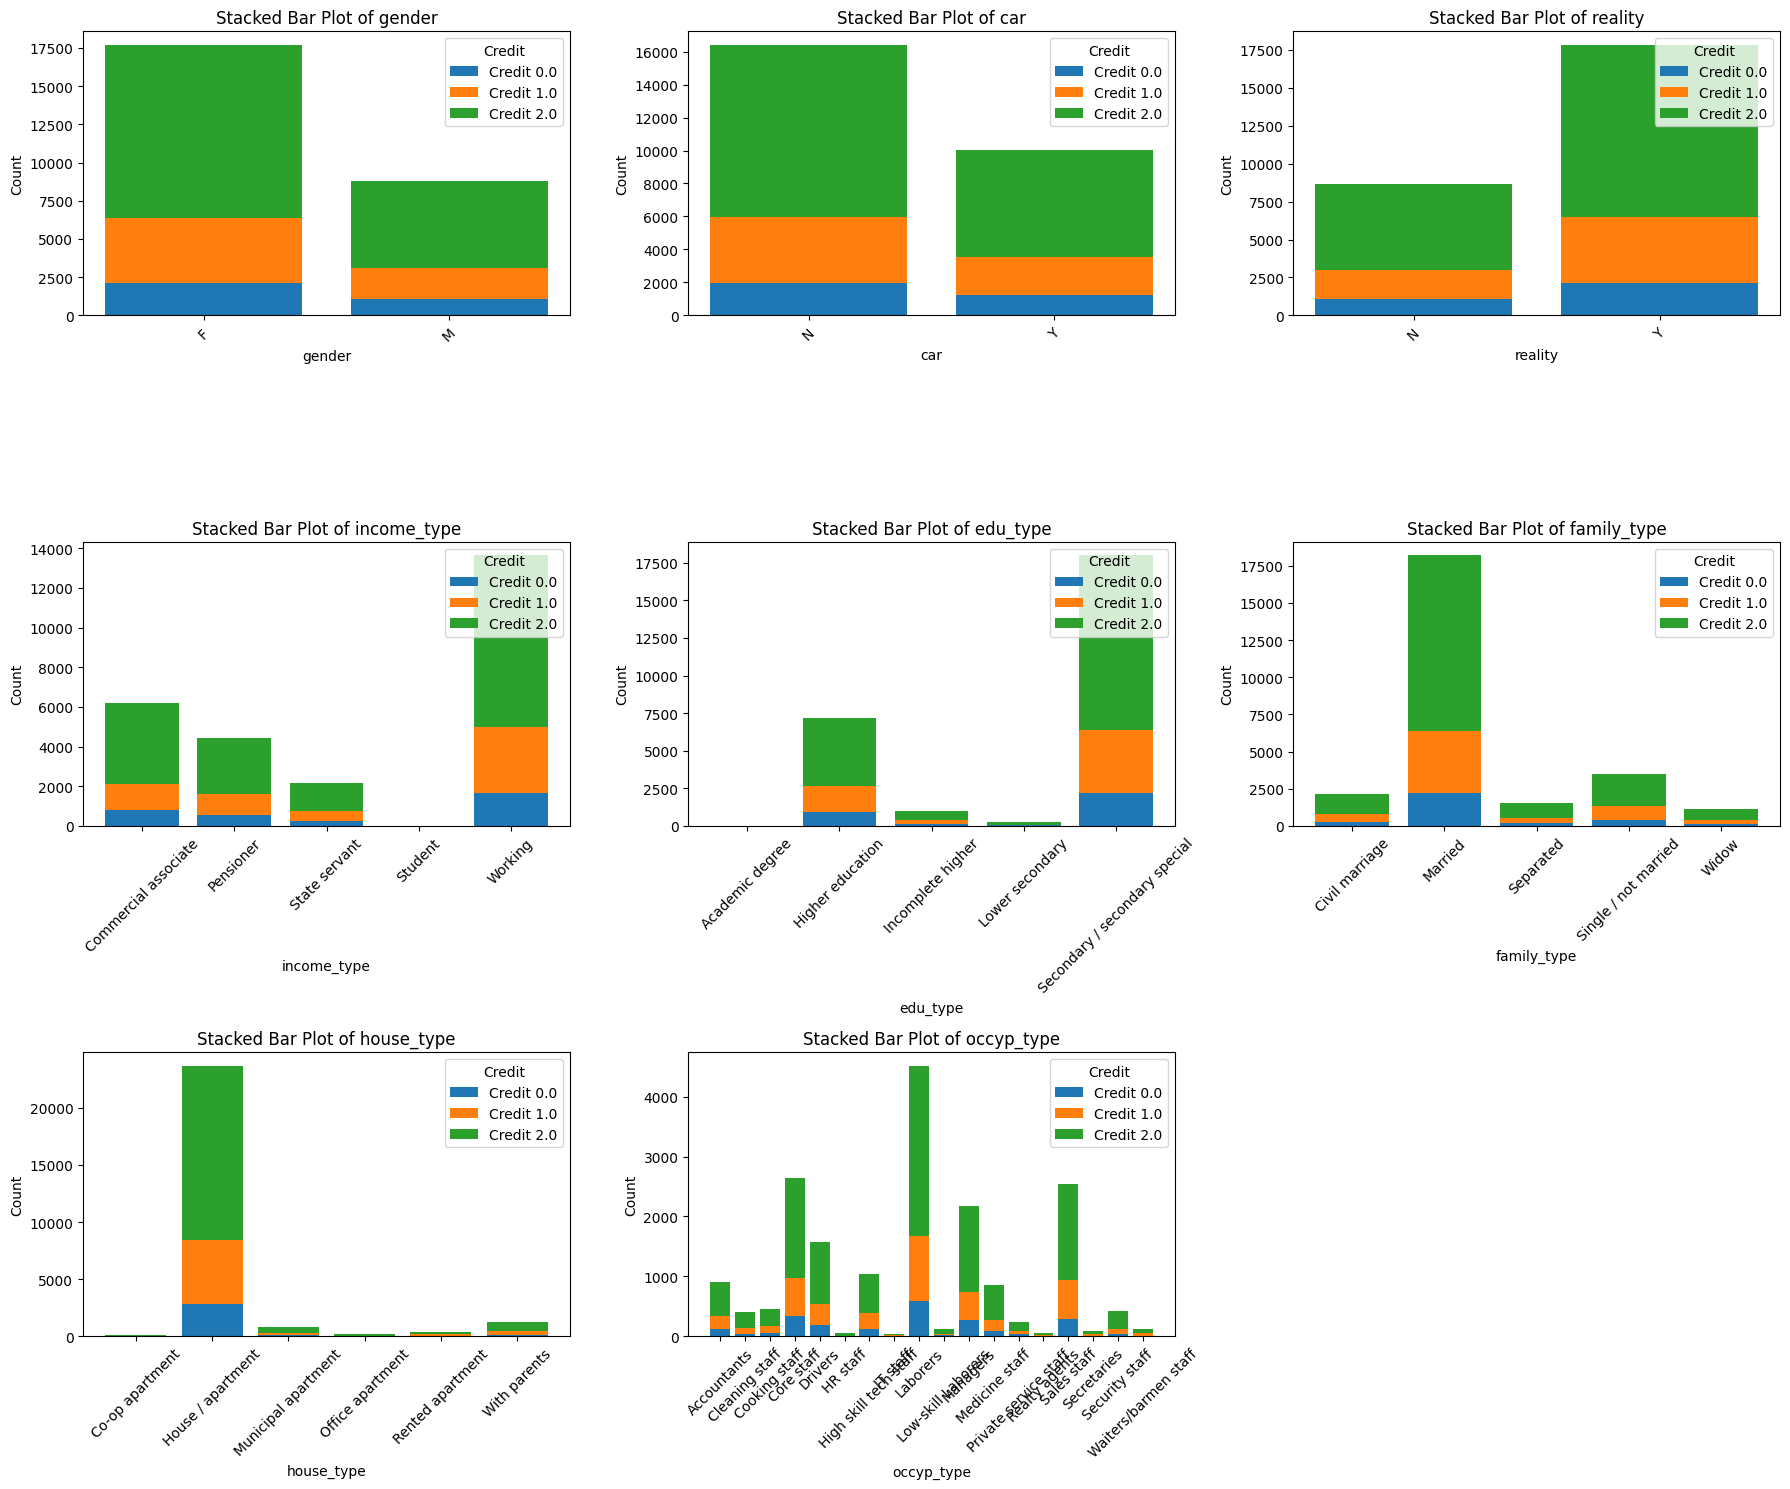

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np

# credit 데이터 합치기
combined_data = x_categorical.copy()
combined_data['credit'] = y_train.copy()  # 동일한 인덱스를 기준으로 credit 추가

# 범주형 변수 설정
categorical_columns = ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']
cols = 3
num_vars = len(categorical_columns)
rows = math.ceil(num_vars / cols)  # 필요한 행(row) 수 계산

# 서브플롯 생성
fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 5))  # 전체 figure 크기 조정
axes = axes.flatten()  # 2D 배열을 1D로 변환하여 인덱싱 편리하게

# 그래프 그리기
for idx, var_nm in enumerate(categorical_columns):
    ax = axes[idx]

    # 데이터 그룹화 및 스택 데이터 계산
    stacked_data = combined_data.groupby([var_nm, 'credit']).size().unstack(fill_value=0)

    # 각 카테고리의 막대 그래프 그리기
    bottom_values = np.zeros(len(stacked_data))
    for credit_value in stacked_data.columns:
        ax.bar(stacked_data.index, stacked_data[credit_value], bottom=bottom_values, label=f'Credit {credit_value}')
        bottom_values += stacked_data[credit_value]

    # 그래프 설정
    ax.set_title(f'Stacked Bar Plot of {var_nm}')
    ax.set_xlabel(var_nm)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Credit', loc='upper right')

# 빈 서브플롯 숨기기
for i in range(num_vars, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

* occyp_type(직업유형)
  * occyp_type의 경우는 앞서 확인했을 때, 유일하게 결측치가 있으면서 결측치가 많았음
  * 따라서 삭제가 아닌 대체가 필요한데, 결측치의 처리를 위해 결측치가 가지는 의미나 맥락을 고민해봄
    * '무직'이라는 컬럼이 없는데, 결측치가 '무직'을 의미하는 것은 아닐지 확인
      * DAYS_EMPLOYED변수가 양수인(직업이 없는) 경우를 제외해도, 여전히 Null값이 존재
      * 무직이어서 Null인 값도 있지만, 무직이 아님에도 Null인 경우도 있음
      * Null값에 따른 평균/최대/최소 임금 등을 시각해보았으나 별도의 인사이트는 얻지 못함
  * **occyp_type(직업유형)의 결측치 중, DAYS_EMPLOYED변수가 양수인 경우는 'NoJob', 이외는 'Missing'으로 대체**하기로 함
    * sklearn의 SimpleImputer라는 것도 있었으나, 최빈값 대체할 것은 아니므로 사용하지 않음

In [ ]:
# occyp_type(직업유형)의 값 확인
x_categorical.occyp_type.value_counts()

occyp_type
Laborers                 4512
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: count, dtype: int64

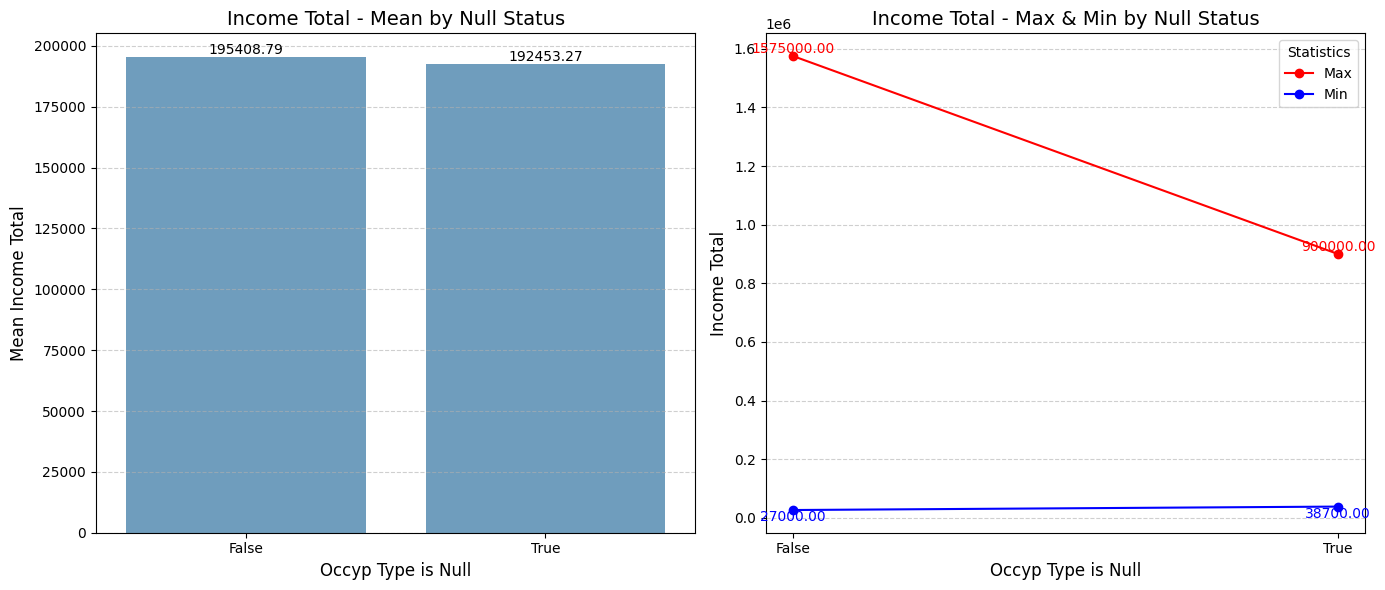

In [ ]:
# Null값에 따른 평균/최대/최소 임금 시각화. 별도의 인사이트는 얻지 못함

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 결측 여부 컬럼 추가
x_train_temp = x_train[(x_train['DAYS_EMPLOYED']!=365243)].copy()
x_train_temp['occyp_type_isnull'] = x_train_temp['occyp_type'].isnull()

# 그룹별 income_total의 평균, 최대, 최소 계산
summary_stats = x_train_temp.groupby('occyp_type_isnull')['income_total'].agg(['mean', 'max', 'min']).reset_index()
summary_stats.columns = ['IsNull', 'Mean', 'Max', 'Min']

# Boolean 값을 문자열로 변환
summary_stats['IsNull'] = summary_stats['IsNull'].astype(str)

# 서브플롯 생성
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1행 2열의 서브플롯 생성

# 왼쪽 플롯: 평균(Mean)
sns.barplot(ax=axes[0], x='IsNull', y='Mean', data=summary_stats, alpha=0.7)
for i, row in summary_stats.iterrows():
    axes[0].text(i, row['Mean'], f"{row['Mean']:.2f}", color='black', ha='center', va='bottom', fontsize=10)
axes[0].set_title('Income Total - Mean by Null Status', fontsize=14)
axes[0].set_xlabel('Occyp Type is Null', fontsize=12)
axes[0].set_ylabel('Mean Income Total', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

# 오른쪽 플롯: 최대(Max)와 최소(Min)
axes[1].plot(summary_stats['IsNull'], summary_stats['Max'], color='red', marker='o', label='Max')
axes[1].plot(summary_stats['IsNull'], summary_stats['Min'], color='blue', marker='o', label='Min')
for i, row in summary_stats.iterrows():
    axes[1].text(i, row['Max'], f"{row['Max']:.2f}", color='red', ha='center', va='bottom', fontsize=10)
    axes[1].text(i, row['Min'], f"{row['Min']:.2f}", color='blue', ha='center', va='top', fontsize=10)
axes[1].set_title('Income Total - Max & Min by Null Status', fontsize=14)
axes[1].set_xlabel('Occyp Type is Null', fontsize=12)
axes[1].set_ylabel('Income Total', fontsize=12)
axes[1].legend(title='Statistics', loc='upper right')
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

## y값 불균형도 확인

* (변수 설명에 따르면)숫자가 낮을수록 신용도가 높은데, 신용도가 낮은 경우가 64%로 많은편임

In [ ]:
y_train.value_counts()

credit
2.0    16968
1.0     6267
0.0     3222
Name: count, dtype: int64

In [ ]:
y_train.value_counts(normalize=True)

credit
2.0    0.641343
1.0    0.236875
0.0    0.121783
Name: proportion, dtype: float64

## [전처리] 결측/이상치 처리 및 표준화/정규화 등

### 결측치 대체 (공통)

* 모든(수치형/범주형) 변수를 통틀어 1개의 변수만 가지고 있던 결측치를 먼저 대체
  * 범주형 변수 중 occyp_type(직업유형)의 결측치를 조건에 따라 'NoJob' 또는 'Missing'으로 대체
  * 결측치 대체 후, Unique값 array 값이 아래와 같이 변경되었음

In [ ]:
# 결측치 대체 전

print(f"Unique data수 : {len(x_train.occyp_type.unique())}")
x_train.occyp_type.unique()

Unique data수 : 19


array([None, 'Laborers', 'Managers', 'Sales staff',
       'High skill tech staff', 'Core staff', 'Drivers', 'Medicine staff',
       'Accountants', 'Realty agents', 'Security staff', 'Cleaning staff',
       'Private service staff', 'Cooking staff', 'Secretaries',
       'HR staff', 'IT staff', 'Low-skill Laborers',
       'Waiters/barmen staff'], dtype=object)

In [ ]:
# 결측치 대체 후

import pandas as pd

def fill_occyp_type(row):
    if pd.isna(row['occyp_type']):
        if row['DAYS_EMPLOYED'] > 0:
            return 'NoJob'
        else:
            return 'Missing'
    return row['occyp_type']

x_train['occyp_type'] = x_train.apply(fill_occyp_type, axis=1)

# 변화 확인
print(f"Unique data수 : {len(x_train.occyp_type.unique())}")
x_train.occyp_type.unique()

Unique data수 : 20


array(['Missing', 'Laborers', 'Managers', 'Sales staff',
       'High skill tech staff', 'Core staff', 'Drivers', 'Medicine staff',
       'Accountants', 'NoJob', 'Realty agents', 'Security staff',
       'Cleaning staff', 'Private service staff', 'Cooking staff',
       'Secretaries', 'HR staff', 'IT staff', 'Low-skill Laborers',
       'Waiters/barmen staff'], dtype=object)

In [ ]:
# 범주형, 수치형 변수로 나누어 작업

x_categorical = x_train.select_dtypes(include=['object'])
x_numerical = x_train.select_dtypes(include=['float64', 'int64'])

### 수치형 변수 전처리

* 값이 0, 1로 유무만을 나타내는 변수는 처리하지 않음
  * 대상 : FLAG_MOBIL, work_phone, phone, email

* 값이 음수인 변수(역산하는 변수)는 아래와 같이 처리
  * 대상 : DAYS_BIRTH, DAYS_EMPLOYED, begin_month
  * (공통) 표준화/정규화/로그변환 전, 최소값 조정 진행
  * **로그변환** : `DAYS_EMPLOYED`
    * 무직임을 표현하려면 양수이기만 하면 되므로, 기준의 365243을 1로 대체
    * IQR기준 이상치가 있는 것으로 판명되긴하나, 값이 많고 처리기준을 정하기 어려워, 양수를 1로 대체하여 숫자 범위를 한번 줄인 후, 로그변환 진행
  * **표준화** : `DAYS_BIRTH`, `begin_month`
    * IQR기준 이상치를 보지 못했으며, 첨도가 -1정도로 **표준화** 진행
    * 향후 사용할 모델에 따라 변경할 수 있음
    * 아래 기준은 GPT로 1차적으로 받아본 기준이며, 실제 진행 전에 좀 더 알아보고 결정
      * 표준화 : 선형모델, SVM, KNN
      * 정규화 : 거리기반 모델(클러스터링, KNN)

* 이외의 변수는 정규화/표준화 중, 아래의 관점을 기준으로 **정규화를 적용**하기로 함
  * 대상 : child_num, income_total, family_size
  * 분포상 중심에서 떨어진 이상치를 보유하고있으며, 이상치 대체를 선행하기엔 영향을 알기 어려워 진행하지 않음
  * 표준화는 이상치의 영향을 많이 받을 수 있다는 점에서 정규화로 선택함

In [ ]:
# 수치형변수 현황 확인
x_numerical.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,26457.0,13228.000000,7637.622372,0.0,6614.0,13228.0,19842.0,26456.0
child_num,26457.0,0.428658,0.747326,0.0,0.0,0.0,1.0,19.0
income_total,26457.0,187306.524493,101878.367995,27000.0,121500.0,157500.0,225000.0,1575000.0
DAYS_BIRTH,26457.0,-15958.053899,4201.589022,-25152.0,-19431.0,-15547.0,-12446.0,-7705.0
DAYS_EMPLOYED,26457.0,59068.750728,137475.427503,-15713.0,-3153.0,-1539.0,-407.0,365243.0
FLAG_MOBIL,26457.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
work_phone,26457.0,0.224742,0.417420,0.0,0.0,0.0,0.0,1.0
phone,26457.0,0.294251,0.455714,0.0,0.0,0.0,1.0,1.0
email,26457.0,0.091280,0.288013,0.0,0.0,0.0,0.0,1.0
family_size,26457.0,2.196848,0.916717,1.0,2.0,2.0,3.0,20.0


#### 이상치 대체(DAYS_EMPLOYED)

In [ ]:
# 이상치 대체 전
x_numerical['DAYS_EMPLOYED'].max()

365243

In [ ]:
# 이상치 대체 후

# DAYS_EMPLOYED : 365243를 1로 대체
x_numerical['DAYS_EMPLOYED'] = x_numerical['DAYS_EMPLOYED'].apply(lambda x: 1 if x == 365243.0 else x)

x_numerical['DAYS_EMPLOYED'].max()

1

#### 최소값 조정(음수변수들 : DAYS_BIRTH, DAYS_EMPLOYED, begin_month)

In [ ]:
# 최소값 변환 전
 
x_numerical[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']].min()

DAYS_BIRTH      -25152.0
DAYS_EMPLOYED   -15713.0
begin_month        -60.0
dtype: float64

In [ ]:
# 최소값 변환 후

# min() * -1  을 더하여 변환
x_numerical[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']] = x_numerical[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']] + x_numerical[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']].min()*-1

x_numerical[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']].min()

DAYS_BIRTH       0.0
DAYS_EMPLOYED    0.0
begin_month      0.0
dtype: float64

#### 로그변환('DAYS_EMPLOYED')

In [ ]:
# 로그변환 전

x_numerical['DAYS_EMPLOYED'].head(5)

0    11004.0
1    14173.0
2    11279.0
3    13621.0
4    13608.0
Name: DAYS_EMPLOYED, dtype: float64

In [ ]:
# 로그변환 후

x_numerical['DAYS_EMPLOYED'] = x_numerical['DAYS_EMPLOYED'].apply(lambda x : np.log1p(x))
x_numerical['DAYS_EMPLOYED'].head(5)

0    9.306105
1    9.559165
2    9.330787
3    9.519441
4    9.518487
Name: DAYS_EMPLOYED, dtype: float64

#### 표준화 적용('DAYS_BIRTH', 'begin_month')

In [ ]:
# 표준화 적용 전

x_numerical[['DAYS_BIRTH', 'begin_month']].head(5)

,DAYS_BIRTH,begin_month
0,11253.0,54.0
1,13772.0,55.0
2,6065.0,38.0
3,10064.0,23.0
4,10115.0,34.0


In [ ]:
# 표준화 적용 후
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
x_numerical[['DAYS_BIRTH', 'begin_month']] = std_scaler.fit_transform(x_numerical[['DAYS_BIRTH', 'begin_month']])
x_numerical[['DAYS_BIRTH', 'begin_month']].head(5)

,DAYS_BIRTH,begin_month
0,0.490075,1.215231
1,1.089621,1.275620
2,-0.744719,0.249003
3,0.207081,-0.656836
4,0.219220,0.007446


#### 정규화 적용(child_num, income_total, family_size)

In [ ]:
# 정규화 적용 전

x_numerical[['child_num', 'income_total', 'family_size']].head(5)

,child_num,income_total,family_size
0,0,202500.0,2.0
1,1,247500.0,3.0
2,0,450000.0,2.0
3,0,202500.0,2.0
4,0,157500.0,2.0


In [ ]:
# 정규화 적용 후

from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
x_numerical[['child_num', 'income_total', 'family_size']]  = min_max_scaler.fit_transform(x_numerical[['child_num', 'income_total', 'family_size']] )
x_numerical[['child_num', 'income_total', 'family_size']].head(5)

,child_num,income_total,family_size
0,0.000000,0.113372,0.052632
1,0.052632,0.142442,0.105263
2,0.000000,0.273256,0.052632
3,0.000000,0.113372,0.052632
4,0.000000,0.084302,0.052632


### 범주형 변수 전처리

* Ordinal변수에 대해서는 Label인코딩 적용
  * 대상 : edu_type
* Unique값이 2~6개인 변수에 대해서는 One-hot Encoding 적용
  * 대상 : 'gender', 'car', 'reality', 'income_type', 'family_type', 'house_type'
  * 22개 컬럼(변수) 추가될 것으로 예상
* Unique값이 20개인 변수에 대해서는, 아래의 방법을 적용
  * 대상 : 'occyp_type'
  * 변수의 과도한 증가와, 상하관계 착각을 막기위해 다른 방법을 고민
  * Target인코딩이라는 것을 적용해보기로 함 (with LeaveOneOutEncoder)
    * 향후 적용여부에 따라 모델성능이 저하되거나 유의미하지 않다면 변수 제외를 고려(계산복잡성 등을 고려함)

In [ ]:
x_categorical.describe()

,gender,car,reality,income_type,edu_type,family_type,house_type,occyp_type
count,26457,26457,26457,26457,26457,26457,26457,26457
unique,2,2,2,5,5,5,6,20
top,F,N,Y,Working,Secondary / secondary special,Married,House / apartment,Laborers
freq,17697,16410,17830,13645,17995,18196,23653,4512


#### Label인코딩 : Ordinal변수

In [ ]:
# Label인코딩 전

x_categorical['edu_type'].unique()

array(['Higher education', 'Secondary / secondary special',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

In [ ]:
# Label인코딩 후 (Order값은 낮은 것부터 입력)

from sklearn.preprocessing import OrdinalEncoder

order = [
    'Lower secondary',
    'Secondary / secondary special',
    'Incomplete higher',
    'Higher education',
    'Academic degree'
]

o_encoder = OrdinalEncoder(categories=[order])
oe_df = o_encoder.fit_transform(x_categorical[['edu_type']])
x_categorical['edu_type'] = oe_df.flatten()

In [ ]:
x_categorical['edu_type'].unique()

array([3., 1., 2., 0., 4.])

#### One-hot인코딩 : Unique값이 2~6개인 변수

In [ ]:
# One-hot인코딩 전

x_categorical.columns

Index(['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type',
       'house_type', 'occyp_type'],
      dtype='object')

In [ ]:
# One-hot 인코딩 데이터프레임 생성

from sklearn.preprocessing import OneHotEncoder

one_hot_columns = ['gender', 'car', 'reality', 'income_type', 'family_type', 'house_type']

oh_encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = oh_encoder.fit_transform(x_categorical[one_hot_columns])
encoded_col_names = oh_encoder.get_feature_names_out(input_features=one_hot_columns)

df_onehot_encoded = pd.DataFrame(onehot_encoded, columns=encoded_col_names, index=x_categorical.index)
df_onehot_encoded.columns

Index(['gender_F', 'gender_M', 'car_N', 'car_Y', 'reality_N', 'reality_Y',
       'income_type_Commercial associate', 'income_type_Pensioner',
       'income_type_State servant', 'income_type_Student',
       'income_type_Working', 'family_type_Civil marriage',
       'family_type_Married', 'family_type_Separated',
       'family_type_Single / not married', 'family_type_Widow',
       'house_type_Co-op apartment', 'house_type_House / apartment',
       'house_type_Municipal apartment', 'house_type_Office apartment',
       'house_type_Rented apartment', 'house_type_With parents'],
      dtype='object')

In [ ]:
# Ont-hot인코딩 대상 컬럼 미리 Drop (별도로 생성한 인코딩된 데이터프레임을 다시 합칠 예정)

x_categorical.drop(one_hot_columns, axis=1, inplace=True)
x_categorical.columns

Index(['edu_type', 'occyp_type'], dtype='object')

In [ ]:
# One-hot인코딩 후

# Ont-hot인코딩된 데이터프레임 Concat
x_categorical = pd.concat([x_categorical, df_onehot_encoded], axis=1)

# Ont-hot인코딩된 최종컬럼 확인
x_categorical.columns

Index(['edu_type', 'occyp_type', 'gender_F', 'gender_M', 'car_N', 'car_Y',
       'reality_N', 'reality_Y', 'income_type_Commercial associate',
       'income_type_Pensioner', 'income_type_State servant',
       'income_type_Student', 'income_type_Working',
       'family_type_Civil marriage', 'family_type_Married',
       'family_type_Separated', 'family_type_Single / not married',
       'family_type_Widow', 'house_type_Co-op apartment',
       'house_type_House / apartment', 'house_type_Municipal apartment',
       'house_type_Office apartment', 'house_type_Rented apartment',
       'house_type_With parents'],
      dtype='object')

#### Target인코딩 : Ordinal이 아니고 Unique값이 많은 변수

In [ ]:
# Target인코딩 전
x_categorical['occyp_type'].__len__

<bound method Series.__len__ of 0               Missing
1              Laborers
2              Managers
3           Sales staff
4              Managers
              ...      
26452        Core staff
26453           Missing
26454        Core staff
26455          Laborers
26456    Security staff
Name: occyp_type, Length: 26457, dtype: object>

In [ ]:
# Target인코딩 후

import category_encoders as ce
import joblib

x_column = 'occyp_type'

leave_one_out_encoder = ce.LeaveOneOutEncoder(cols=x_column, sigma=0.1, return_df=True)
df_target_encoded = leave_one_out_encoder.fit_transform(x_categorical[x_column], y_train)

joblib.dump(leave_one_out_encoder, 'encoder_leave_one_out.pkl')

df_target_encoded['occyp_type'].__len__

<bound method Series.__len__ of 0        1.570514
1        1.621321
2        1.552459
3        1.461605
4        1.727354
           ...   
26452    1.405981
26453    1.556405
26454    1.389829
26455    1.376017
26456    1.597510
Name: occyp_type, Length: 26457, dtype: float64>

In [ ]:
x_categorical['occyp_type'] = df_target_encoded['occyp_type']

## 전처리된 데이터 저장

In [ ]:
# 범주형/수치형 변수로 나누어 작업한 파일 합치기
x_train_preprocessed = pd.concat([x_categorical, x_numerical], axis=1)
x_train_preprocessed

,edu_type,occyp_type,gender_F,gender_M,car_N,car_Y,reality_N,reality_Y,income_type_Commercial associate,income_type_Pensioner,...,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month
0,3.0,1.570514,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.000000,0.113372,0.490075,9.306105,1,0,0,0,0.052632,1.215231
1,1.0,1.621321,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.052632,0.142442,1.089621,9.559165,1,0,0,1,0.105263,1.275620
2,3.0,1.552459,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.000000,0.273256,-0.744719,9.330787,1,0,1,0,0.052632,0.249003
3,1.0,1.461605,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.000000,0.113372,0.207081,9.519441,1,0,1,0,0.052632,-0.656836
4,3.0,1.727354,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.000000,0.084302,0.219220,9.518487,1,0,0,0,0.052632,0.007446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,1.0,1.405981,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.105263,0.127907,0.923252,9.527338,1,0,0,0,0.157895,1.456788
26453,3.0,1.556405,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.052632,0.098837,0.158765,9.490922,1,0,0,0,0.052632,-1.260729
26454,1.0,1.389829,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.000000,0.171512,1.398558,9.525078,1,0,0,0,0.052632,0.067835
26455,2.0,1.376017,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.000000,0.093023,1.383563,9.655475,1,0,0,0,0.000000,-1.985400


In [ ]:
# CSV저장
x_train_preprocessed.to_csv('train_preprocessed.csv')

In [ ]:
# DB저장
db_controller.df_to_table('train_pre', x_train_preprocessed)

In [ ]:
# DB저장된 내용 확인
db_controller.search_db_show_df("SELECT * FROM train_pre")

,edu_type,occyp_type,gender_F,gender_M,car_N,car_Y,reality_N,reality_Y,income_type_Commercial associate,income_type_Pensioner,...,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month
0,3.0,1.570514,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.000000,0.113372,0.490075,9.306105,1,0,0,0,0.052632,1.215231
1,1.0,1.621321,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.052632,0.142442,1.089621,9.559165,1,0,0,1,0.105263,1.275620
2,3.0,1.552459,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.000000,0.273256,-0.744719,9.330787,1,0,1,0,0.052632,0.249003
3,1.0,1.461605,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.000000,0.113372,0.207081,9.519441,1,0,1,0,0.052632,-0.656836
4,3.0,1.727354,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.000000,0.084302,0.219220,9.518487,1,0,0,0,0.052632,0.007446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,1.0,1.405981,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.105263,0.127907,0.923252,9.527338,1,0,0,0,0.157895,1.456788
26453,3.0,1.556405,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.052632,0.098837,0.158765,9.490922,1,0,0,0,0.052632,-1.260729
26454,1.0,1.389829,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.000000,0.171512,1.398558,9.525078,1,0,0,0,0.052632,0.067835
26455,2.0,1.376017,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.000000,0.093023,1.383563,9.655475,1,0,0,0,0.000000,-1.985400


## 향후 Test데이터셋에 쓰기위한 전처리 코드 정리

In [ ]:
import pandas as pd
import os
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, OneHotEncoder
import category_encoders as ce
import joblib
from pkb_sqlite3 import DB_sqlite3

def preprocess_x_data(train_or_test:str, dataset:list[DataFrame], output_name:dict)->None:

    # 파라메터 검증 및 데이터셋 복사
    if train_or_test == 'train':
        if len(dataset) == 2:
            x_train = dataset[0].copy()
            y_train = dataset[1].copy()
        else:
            return 'train인 경우 x,y 데이터가 필요합니다'
    elif train_or_test == 'test':
        if len(dataset) == 1:
            x_train = dataset[0].copy()
        else:
            return 'test인 경우 x 데이터만 필요합니다'
    else:
        return 'train 또는 test만 입력 가능합니다'

    
    # (공통)결측치 대체 : occyp_type
    def fill_occyp_type(row):
            if pd.isna(row['occyp_type']):
                if row['DAYS_EMPLOYED'] > 0:
                    return 'NoJob'
                else:
                    return 'Missing'
            return row['occyp_type']

    x_train['occyp_type'] = x_train.apply(fill_occyp_type, axis=1)

    # 범주형/수치형 변수로 분할하여 작업
    x_numerical = x_train.select_dtypes(include=['float64', 'int64'])
    x_categorical = x_train.select_dtypes(include=['object'])

    # (수치형변수 전처리) 이상치 대체   *** 주의 : 표준화 전에 수행되어야 함
    x_numerical['DAYS_EMPLOYED'] = x_numerical['DAYS_EMPLOYED'].apply(lambda x: 1 if x == 365243.0 else x)

    # (수치형변수 전처리) 최소값 조정
    x_numerical[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']] = x_numerical[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']] + x_numerical[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']].min()*-1

    # (수치형변수 전처리) 로그변환
    x_numerical['DAYS_EMPLOYED'] = x_numerical['DAYS_EMPLOYED'].apply(lambda x : np.log1p(x))

    # (수치형변수 전처리) 표준화
    std_scaler = StandardScaler()
    x_numerical[['DAYS_BIRTH', 'begin_month']] = std_scaler.fit_transform(x_numerical[['DAYS_BIRTH', 'begin_month']])

    # (수치형변수 전처리) 정규화
    min_max_scaler = MinMaxScaler()
    x_numerical[['child_num', 'income_total', 'family_size']]  = min_max_scaler.fit_transform(x_numerical[['child_num', 'income_total', 'family_size']] )

    # (범주형변수 전처리) Label인코딩 (Ordinal변수)
    order = [
        'Lower secondary',
        'Secondary / secondary special',
        'Incomplete higher',
        'Higher education',
        'Academic degree'
    ]

    o_encoder = OrdinalEncoder(categories=[order])
    oe_df = o_encoder.fit_transform(x_categorical[['edu_type']])
    x_categorical['edu_type'] = oe_df.flatten()

    # (범주형변수 전처리) One-hot인코딩 (Unique값 6개 이하)

    ## One-hot 인코딩 데이터프레임 생성
    one_hot_columns = ['gender', 'car', 'reality', 'income_type', 'family_type', 'house_type']

    oh_encoder = OneHotEncoder(sparse_output=False)
    onehot_encoded = oh_encoder.fit_transform(x_categorical[one_hot_columns])
    encoded_col_names = oh_encoder.get_feature_names_out(input_features=one_hot_columns)

    df_onehot_encoded = pd.DataFrame(onehot_encoded, columns=encoded_col_names, index=x_categorical.index)

    ## Ont-hot인코딩 대상 컬럼 미리 Drop (별도로 생성한 인코딩된 데이터프레임을 다시 합칠 예정)
    x_categorical.drop(one_hot_columns, axis=1, inplace=True)

    ## Ont-hot인코딩된 데이터프레임 Concat
    x_categorical = pd.concat([x_categorical, df_onehot_encoded], axis=1)

    # (범주형변수 전처리) Target인코딩 (Ordinal이 아니면서 Unique값이 많은 경우)
    x_column = 'occyp_type'
                                
    ## 파일로 저장해둔 인코더가 있으면 로딩, 아니면 생성
    if os.path.isfile('encoder_leave_one_out.pkl'):
        leave_one_out_encoder = joblib.load('encoder_leave_one_out.pkl')
    else:
        leave_one_out_encoder = ce.LeaveOneOutEncoder(cols=x_column, sigma=0.1, return_df=True)

    ## 인코딩된 데이터 생성 및 인코더 업데이트
    if train_or_test == 'train':
        df_target_encoded = leave_one_out_encoder.fit_transform(x_categorical[x_column], y_train)
    elif train_or_test == 'test':
        df_target_encoded = leave_one_out_encoder.transform(x_categorical[x_column])
    joblib.dump(leave_one_out_encoder, 'encoder_leave_one_out.pkl')

    x_categorical['occyp_type'] = df_target_encoded['occyp_type']
    

    # 나누어 작업한 수치형/범주형 변수 합치고 저장
    x_train_preprocessed = pd.concat([x_categorical, x_numerical], axis=1)

    ## CSV저장 
    x_train_preprocessed.to_csv(output_name['csv_file_name']) # 'train_preprocessed.csv'

    ## DB저장 (아래 함수는 이미 테이블이 있는 경우 덮어씀)
    db_controller.df_to_table(output_name['db_table_name'], x_train_preprocessed) # 'train_pre'

    return '작업이 완료되었습니다'


# DB로딩 및 데이터 가져오기
db_controller = DB_sqlite3('Dacon_creditcard_overdue.db')
df_train = db_controller.search_db_show_df('SELECT * FROM train')
df_test = db_controller.search_db_show_df('SELECT * FROM test')
df_sample_submission = db_controller.search_db_show_df('SELECT * FROM sample_submission')

In [ ]:
# train 데이터 전처리
y_train = df_train['credit'].copy()
x_train = df_train.drop('credit',axis=1).copy()

preprocess_x_data(train_or_test='train', 
                  dataset=[x_train, y_train], 
                  output_name={'csv_file_name':'train_preprocessed.csv', 
                               'db_table_name':'train_pre'}
                  )

'작업이 완료되었습니다'

In [ ]:
# 전처리된 데이터 확인
db_controller.search_db_show_df("SELECT * FROM train_pre").head(3)

,edu_type,occyp_type,gender_F,gender_M,car_N,car_Y,reality_N,reality_Y,income_type_Commercial associate,income_type_Pensioner,...,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month
0,3.0,1.477037,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.000000,0.113372,0.556662,11004.0,1,0,0,0,0.052632,1.215231
1,1.0,1.417380,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.052632,0.142442,0.870181,14173.0,1,0,0,1,0.105263,1.275620
2,3.0,1.452349,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.000000,0.273256,-0.402621,11279.0,1,0,1,0,0.052632,0.249003


In [ ]:
# test 데이터 전처리
df_test = db_controller.search_db_show_df('SELECT * FROM test')

preprocess_x_data(train_or_test='test', 
                  dataset=[df_test], 
                  output_name={'csv_file_name':'test_preprocessed.csv', 
                               'db_table_name':'test_pre'}
                  )

'작업이 완료되었습니다'

In [ ]:
# 전처리된 데이터 확인
db_controller.search_db_show_df("SELECT * FROM test_pre").head(3)

,edu_type,occyp_type,gender_F,gender_M,car_N,car_Y,reality_N,reality_Y,income_type_Commercial associate,income_type_Pensioner,income_type_State servant,income_type_Student,income_type_Working,family_type_Civil marriage,family_type_Married,family_type_Separated,family_type_Single / not married,family_type_Widow,house_type_Co-op apartment,house_type_House / apartment,house_type_Municipal apartment,house_type_Office apartment,house_type_Rented apartment,house_type_With parents,index,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month
0,1.0,1.514196,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,26457,-0.596243,-0.714468,0.179018,15662.0,1,0,1,0,-0.225667,0.000000
1,3.0,1.502646,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,26458,-0.596243,-0.492869,0.350337,6990.0,1,0,1,0,-0.225667,0.400000
2,1.0,1.500443,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,26459,-0.596243,-1.139229,0.524543,15444.0,1,1,1,0,-0.225667,0.333333


In [ ]:
# DB연결해제
db_controller.close()